In [1]:
from rdkit import Chem
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, as_completed

import torch
from torch import nn
import torch.nn.functional as F

import torch_geometric as tg
from torch_geometric.data import Dataset, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [2]:
def one_hot_encoding_unk(value, choices: list) -> list:
    # One hot encoding with unknown value handling
    # If the value is in choices, it puts a 1 at the corresponding index
    # Otherwise, it puts a 1 at the last index (unknown)
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding


def get_atom_features(atom) -> list:
    # Returns a feature list for the atom
    # Concatenates the one-hot encodings into a single list
    features = [
        one_hot_encoding_unk(atom.GetSymbol(), ['B','Be','Br','C','Cl','F','I','N','Nb','O','P','S','Se','Si','V','W']),
        one_hot_encoding_unk(atom.GetTotalDegree(), [0, 1, 2, 3, 4, 5]),
        one_hot_encoding_unk(atom.GetFormalCharge(), [-1, -2, 1, 2, 0]),
        one_hot_encoding_unk(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4]),
        one_hot_encoding_unk(int(atom.GetHybridization()),[
                                                        Chem.rdchem.HybridizationType.SP,
                                                        Chem.rdchem.HybridizationType.SP2,
                                                        Chem.rdchem.HybridizationType.SP3,
                                                        Chem.rdchem.HybridizationType.SP3D,
                                                        Chem.rdchem.HybridizationType.SP3D2
                                                        ]),
        [1 if atom.GetIsAromatic() else 0],
        [atom.GetMass() * 0.01]
    ]
    return sum(features, []) # Flatten the list into a single list


def get_bond_features(bond) -> list:
    # Returns a one-hot encoded feature list for the bond
    bond_fdim = 7

    if bond is None:
        fbond = [1] + [0] * (bond_fdim - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # Zeroth index indicates if bond is None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
    return fbond

In [3]:
class MolGraph:
    # Returns a custom molecular graph for a given SMILES string
    # Contains atom, bond features and node connectivity
    def __init__(self, smiles: str):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = Chem.MolFromSmiles(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for atom_1 in range(n_atoms):
            self.f_atoms.append(get_atom_features(mol.GetAtomWithIdx(atom_1)))

            for atom_2 in range(atom_1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(atom_1, atom_2)
                if bond is None:
                    continue
                f_bond = get_bond_features(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond) # Bond features are added twice for both directions
                self.edge_index.extend([(atom_1, atom_2), (atom_2, atom_1)]) # Edge index list with tuples of connected nodes instead of adjacency matrix

In [ ]:
class ChemDataset(Dataset):
    def __init__(self, smiles: str, labels, flip_prob: float=0.25, gauss_std: float=0.25, precompute: bool=True):
        super(ChemDataset, self).__init__()
        self.smiles = smiles
        self.labels = labels
        self.cache = {}
        self.flip_prob = flip_prob
        self.gauss_std = gauss_std
        self.precompute = precompute

        # Precomputing the dataset so the get method is faster, and the GPU doesn't have to wait for the CPU
        if precompute:
            print(f"Precomputing data...")
            with ThreadPoolExecutor(max_workers=8) as executor:
                futures = [
                    executor.submit(self.process_key , idx)
                    for idx in range(len(self.smiles))
                ]

                for future in as_completed(futures):
                    future.result()

            print(f"Precomputation finished. {len(self.cache)} molecules cached.")

    def process_key(self, key):
        # Process the key to get the corresponding molecule graph
        # If the molecule is already cached, return it
        smiles = self.smiles[key]
        if smiles in self.cache.keys():
            mol = self.cache[smiles]
        else:
            molgraph = MolGraph(smiles)
            mol = self.molgraph2data(molgraph, key)
            self.cache[smiles] = mol
        return mol

    def molgraph2data(self, molgraph, key):
        data = tg.data.Data()

        # Coverting all features and labels to tensors
        # And adding it to the data object
        data.x = torch.tensor(molgraph.f_atoms, dtype=torch.float)
        data.edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
        data.edge_attr = torch.tensor(molgraph.f_bonds, dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        data.smiles = self.smiles[key]

        if self.flip_prob > 0 or self.gauss_std > 0:
            # Create a deep copy to avoid modifying original data
            x_noisy = deepcopy(data.x)
            
            # Apply bit flipping to binary features if probability > 0
            if self.flip_prob > 0:
                binary_features = x_noisy[:, :-1]  # All but last column, which contains mass
                flip_mask = torch.rand_like(binary_features) < self.flip_prob
                binary_features[flip_mask] = 1.0 - binary_features[flip_mask]  # Flip 0->1 and 1->0
            
            # Apply Gaussian noise to continuous feature if std > 0
            if self.gauss_std > 0:
                mass_feature = x_noisy[:, -1:]  # Just the last column, which contains mass
                mass_feature += torch.randn_like(mass_feature) * self.gauss_std
            
            data.x_noisy = x_noisy

        return data

    def get(self,key):
        return self.process_key(key)
    
    def __getitem__(self, key):
        # Standard get method for PyTorch Dataset
        return self.process_key(key)

    def len(self):
        return len(self.smiles)

    def __len__(self):
        # Standard len method for PyTorch Dataset
        return len(self.smiles)

In [ ]:
def construct_loader(data_df: pd.DataFrame, smi_column: str, target_column: str, shuffle: bool=True, batch_size: int=16):  
    # Constructs a PyTorch Geometric DataLoader from a DataFrame
    # Takes the SMILES and target column names as input  
    smiles = data_df[smi_column].values
    labels = data_df[target_column].values.astype(np.float32)  
    
    dataset = ChemDataset(smiles, labels)
    loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            pin_memory=True
                       )
    return loader

# Defining the Model

In [ ]:
class DMPNNConv(MessagePassing): 
    # Extending the MessagePassing class from PyG
    # Used for the convolutional layers in the encoder
    def __init__(self, hidden_size: int):
        super(DMPNNConv, self).__init__(aggr='add') # Sum aggregation function, most expressive aggregation as far as I know
        self.lin = nn.Linear(hidden_size, hidden_size)

    def forward(self, edge_index, edge_attr):
        row, _ = edge_index
        # Since each edge is bidirectional, we do two message passings, one for each direction
        aggregated_message = self.propagate(edge_index, x=None, edge_attr=edge_attr)
        reversed_message = torch.flip(edge_attr.view(edge_attr.size(0) // 2, 2, -1), dims=[1]).view(edge_attr.size(0), -1)

        return aggregated_message, self.lin(aggregated_message[row] - reversed_message)

    def message(self, edge_attr):
        return edge_attr

In [7]:
class GNNEncoder(nn.Module):
    def __init__(self, num_node_features: int, num_edge_features: int, hidden_size: int, mode: str, depth: int, dropout: float=0.2):
        super().__init__()
        self.depth = depth
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.mode = mode

        # Encoder layers
        self.edge_init = nn.Linear(num_node_features + num_edge_features, hidden_size)
        self.convs = nn.ModuleList([DMPNNConv(hidden_size) for _ in range(depth)])
        self.edge_to_node = nn.Linear(num_node_features + hidden_size, hidden_size)
        self.pool = global_add_pool  # Not learnable

    def forward(self, data):
        edge_index, edge_attr, batch = data.edge_index, data.edge_attr, data.batch
        
        if self.mode == 'denoise':
            x = data.x_noisy
        elif self.mode == 'predict':
            x = data.x
        else:
            raise ValueError("Invalid mode. Choose 'denoise' or 'predict'.")

        # Edge initialization
        row, _ = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # DMPNN Conv layers
        for layer in self.convs:
            _, h = layer(edge_index, h)
            h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # Edge to node aggregation
        # Re-using the last layer's results for s
        s, _ = self.convs[-1](edge_index, h)
        
        # Due to a recurring error which I can't figure out, we add a check here
        # to ensure that the sizes of s and x match
        # This is a workaround and should be fixed in the future
        # Luckily, this issue only occurs for same-sample batches, which are needed for TTA

        # Pad/truncate s to match x's size
        if s.shape[0] != x.shape[0]:
            # Create tensor with same length as x (regardless of connectivity)
            s_fixed = torch.zeros(x.shape[0], self.hidden_size, device=s.device)
            # Only use the connected nodes we have (first min(s.shape[0], x.shape[0]))
            min_len = min(s.shape[0], x.shape[0]) 
            s_fixed[:min_len] = s[:min_len]
            s = s_fixed

        q = torch.cat([x, s], dim=1)
        h = F.relu(self.edge_to_node(q))

        # Global pooling for the final node embeddings
        embedding = self.pool(h, batch)
        
        return embedding

In [8]:
class GNNDecoder(nn.Module):
    # Decoder for self-supervised denoising task
    # Only reconstructing the node features from the embeddings
    def __init__(self, hidden_size: int, num_node_features: int):
        super().__init__()
        self.lin1 = nn.Linear(hidden_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, num_node_features)

    def forward(self, graph_embedding, batch):
        # The embedding size is (batch_size, hidden_size)
        # We need to expand it per node. First, get how many nodes per graph:
        batch_size = graph_embedding.size(0)
        node_counts = torch.bincount(batch)  # number of nodes in each graph

        # Expand each graph embedding "node_counts[g]" times
        expanded = []
        for g in range(batch_size):
            repeated = graph_embedding[g].unsqueeze(0).repeat(node_counts[g], 1)  # shape = (num_nodes_in_g, hidden_size)
            expanded.append(repeated)

        # Concatenate along node dimension
        expanded = torch.cat(expanded, dim=0)  # total_nodes x hidden_size

        # Decode the node features
        x_hat = F.relu(self.lin1(expanded))
        x_hat = self.lin2(x_hat)  # shape = (total_nodes, num_node_features)

        return x_hat

In [ ]:
class GNNHead(nn.Module):
    # Prediction Head for prediction solubility
    def __init__(self, hidden_size: int, dropout: float=0.2):
        super().__init__()
        # Only some FFN layers which get the embedding as input
        self.ffn1 = nn.Linear(hidden_size, hidden_size)
        self.ffn2 = nn.Linear(hidden_size, 1)
        self.dropout = dropout

    def forward(self, graph_embedding):
        x = F.relu(self.ffn1(graph_embedding))
        x = F.dropout(x, self.dropout, training=self.training)
        return self.ffn2(x).squeeze(-1)

In [ ]:
class GNN(nn.Module):
    # The main GNN model which brings together the encoder, decoder and head
    # It has two modes, denoise and predict
    # The encoder branches out to the decoder and head
    def __init__(self, num_node_features: int, num_edge_features: int, hidden_size: int=300, depth: int=3, mode: str='denoise', dropout: float=0.02):
        super().__init__()
        self.encoder = GNNEncoder(num_node_features, num_edge_features, hidden_size=hidden_size, mode=mode, depth=depth, dropout=dropout)
        self.head = GNNHead(hidden_size=hidden_size, dropout=dropout)
        self.decoder = GNNDecoder(hidden_size=hidden_size, num_node_features=num_node_features)

    def set_mode(self, mode: str):
        # Update the mode in the encoder
        # So the encoder knows if it needs to read noisy or noise-free data
        self.encoder.mode = mode

    def forward(self, data):
        graph_embedding = self.encoder(data)

        if self.encoder.mode == 'predict':
            prediction = self.head(graph_embedding)
            return prediction
        
        elif self.encoder.mode == 'denoise':
            node_features = self.decoder(graph_embedding, data.batch)
            return node_features
    
        else:
            raise ValueError("Invalid mode. Choose 'predict' or 'denoise'.")
        
    def encode(self, data):
        return self.encoder(data)

In [ ]:
class Standardizer:
    # Standardizer for the solubility values
    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std

    def __call__(self, x, rev: bool=False):
        if rev:
            return (x * self.std) + self.mean
        return (x - self.mean) / self.std

# Training

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 16
pretraining_epochs = 30
finetuning_epochs = 30

cuda


In [ ]:
def train_epoch(model, loader, optimizer, loss, mode: str, stdzer: Standardizer=None):
    # Train the model for one epoch, either on denoising or prediction task
    model = model.to(device)
    if mode == 'denoise':
        model.set_mode('denoise')
        model.train()
        loss_all = 0

        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            out = model(data)
            result = loss(out, data.x)
            result.backward()

            optimizer.step()
            loss_all += loss(out, data.x)

        return math.sqrt(loss_all / len(loader.dataset))

    elif mode == 'predict':
        model.set_mode('predict')
        model.train()
        loss_all = 0

        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            out = model(data)
            result = loss(out, stdzer(data.y))
            result.backward()

            optimizer.step()
            loss_all += loss(stdzer(out, rev=True), data.y)

        return math.sqrt(loss_all / len(loader.dataset))
    
    else:
        raise ValueError("Invalid mode. Choose 'denoise' or 'predict'.")


def pred(model, loader, mode: str, stdzer: Standardizer=None):
    # Predict with the model, either on denoising or prediction task
    # No test-time adaptation here, just a simple forward pass
    model = model.to(device)
    if mode == 'denoise':
        model.set_mode('denoise')
        model.eval()

        preds = []
        with torch.no_grad():
            for data in loader:
                data = data.to(device)
                out = model(data)
                preds.extend(out.cpu().detach().flatten().tolist())
                
        return preds

    elif mode == 'predict':
        model.set_mode('predict')
        model.eval()

        preds = []
        with torch.no_grad():
            for data in loader:
                data = data.to(device)
                out = model(data)
                pred = stdzer(out, rev=True)
                preds.extend(pred.cpu().detach().tolist())

        return preds
    
    else:
        raise ValueError("Invalid mode. Choose 'denoise' or 'predict'.")


In [ ]:
torch.manual_seed(0)
data_df = pd.read_csv("AqSolDBc.csv")
# Drop single atoms    
idx_single = [i for i,s in enumerate(data_df['SmilesCurated']) if Chem.MolFromSmiles(s).GetNumAtoms()==1 or '.' in s]
data_df = data_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

test_df = pd.read_csv("OChemUnseen.csv")
# Drop some Nonetypes
idx_nonetype = [i for i,s in enumerate(test_df['SMILES']) if Chem.MolFromSmiles(s) is None] # Got an error for a SMILES which was None
test_df = test_df.drop(idx_nonetype)
if len(idx_nonetype) > 0:
    print(f"Removing {idx_nonetype} due to Nonetypes")

# Drop single atoms
idx_single = [i for i,s in enumerate(test_df['SMILES']) if Chem.MolFromSmiles(s).GetNumAtoms()==1 or '.' in s]
test_df = test_df.drop(idx_single)
if len(idx_single) > 0:
    print(f"Removing {idx_single} due to single atoms")

Removing [1263, 1444, 3605, 3702] due to single atoms


[11:13:58] Explicit valence for atom # 1 P, 6, is greater than permitted


Removing [667] due to Nonetypes
Removing [471, 503, 589, 591, 592, 593, 594, 610, 613, 641, 643, 647, 649, 652, 653, 654, 656, 658, 676, 681, 693, 744, 759, 763, 769, 773, 777, 807, 809, 811, 813, 869, 902, 969, 998] due to single atoms


In [ ]:
train_df, val_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_loader = construct_loader(train_df, 'SmilesCurated', 'ExperimentalLogS', shuffle=True, batch_size=batch_size)
val_loader = construct_loader(val_df, 'SmilesCurated', 'ExperimentalLogS', shuffle=False, batch_size=batch_size)
test_loader = construct_loader(test_df, 'SMILES', 'LogS', shuffle=False, batch_size=batch_size)
print(f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

# Standardizer for the solubility labels
mean = np.mean(train_loader.dataset.labels)
std = np.std(train_loader.dataset.labels)
stdzer = Standardizer(mean, std)

Precomputing data...
Precomputation finished. 7238 molecules cached.
Precomputing data...
Precomputation finished. 805 molecules cached.
Precomputing data...
Precomputation finished. 2215 molecules cached.
Train size: 7238, Val size: 805, Test size: 2215


In [ ]:
model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features).to(device)
loss = nn.MSELoss(reduction='sum').to(device)
print('\n', model, '\n')


 GNN(
  (encoder): GNNEncoder(
    (edge_init): Linear(in_features=51, out_features=300, bias=True)
    (convs): ModuleList(
      (0-2): 3 x DMPNNConv()
    )
    (edge_to_node): Linear(in_features=344, out_features=300, bias=True)
  )
  (head): GNNHead(
    (ffn1): Linear(in_features=300, out_features=300, bias=True)
    (ffn2): Linear(in_features=300, out_features=1, bias=True)
  )
  (decoder): GNNDecoder(
    (lin1): Linear(in_features=300, out_features=300, bias=True)
    (lin2): Linear(in_features=300, out_features=44, bias=True)
  )
) 



In [ ]:
# Pretraining the model on the denoising task
# Different optimizers for different learning rates
denoise_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Unfreeze the encoder
for param in model.encoder.parameters():
    param.requires_grad = True

# Unfreeze the decoder
for param in model.decoder.parameters():
    param.requires_grad = True

# Freeze the prediction head
for param in model.head.parameters():
    param.requires_grad = False

best_denoise_model = deepcopy(model).to(device)
best_denoise_val_loss = 1000000

denoise_train_loss_list = [] # Only needed for plotting
denoise_val_loss_list = []

for epoch in range(0, pretraining_epochs):
    train_loss = train_epoch(model, train_loader, denoise_optimizer, loss, mode='denoise')
    preds = pred(model, val_loader, mode='denoise')
    node_feature_targets = [feature for batch in val_loader for feature in batch.x.cpu().flatten().tolist()]
    val_loss = root_mean_squared_error(preds, node_feature_targets)
    print(f"Epoch {epoch}  Train RMSE: {train_loss:.4g}   Val RMSE: {val_loss:.4g}")

    denoise_train_loss_list.append(train_loss)
    denoise_val_loss_list.append(val_loss)

    if val_loss < best_denoise_val_loss:
        best_denoise_model = deepcopy(model).to(device)
        best_denoise_val_loss = val_loss

Epoch 0  Train RMSE: 6.91   Val RMSE: 0.222
Epoch 1  Train RMSE: 6   Val RMSE: 0.218
Epoch 2  Train RMSE: 5.94   Val RMSE: 0.217
Epoch 3  Train RMSE: 5.91   Val RMSE: 0.217
Epoch 4  Train RMSE: 5.9   Val RMSE: 0.217
Epoch 5  Train RMSE: 5.89   Val RMSE: 0.216
Epoch 6  Train RMSE: 5.88   Val RMSE: 0.216
Epoch 7  Train RMSE: 5.88   Val RMSE: 0.216
Epoch 8  Train RMSE: 5.88   Val RMSE: 0.216
Epoch 9  Train RMSE: 5.87   Val RMSE: 0.216
Epoch 10  Train RMSE: 5.87   Val RMSE: 0.216
Epoch 11  Train RMSE: 5.87   Val RMSE: 0.216
Epoch 12  Train RMSE: 5.87   Val RMSE: 0.216
Epoch 13  Train RMSE: 5.87   Val RMSE: 0.216
Epoch 14  Train RMSE: 5.87   Val RMSE: 0.215
Epoch 15  Train RMSE: 5.86   Val RMSE: 0.215
Epoch 16  Train RMSE: 5.88   Val RMSE: 0.215
Epoch 17  Train RMSE: 5.87   Val RMSE: 0.215
Epoch 18  Train RMSE: 5.86   Val RMSE: 0.215
Epoch 19  Train RMSE: 5.86   Val RMSE: 0.216
Epoch 20  Train RMSE: 5.86   Val RMSE: 0.215
Epoch 21  Train RMSE: 5.86   Val RMSE: 0.215
Epoch 22  Train RMSE: 5.

In [ ]:
# Training the model on the prediction task
# Different optimizers for different learning rates
pred_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Freeze the encoder
for param in model.encoder.parameters():
    param.requires_grad = False

# Freeze the decoder
for param in model.decoder.parameters():
    param.requires_grad = False

# Unfreeze the prediction head
for param in model.head.parameters():
    param.requires_grad = True

best_pred_model = deepcopy(best_denoise_model).to(device)
best_val_loss = 1000000

pred_train_loss_list = [] # Only needed for plotting
pred_val_loss_list = []

for epoch in range(0, finetuning_epochs):
    train_loss = train_epoch(model, train_loader, pred_optimizer, loss, mode='predict', stdzer=stdzer)
    preds = pred(model, val_loader, mode='predict', stdzer=stdzer)
    val_loss = root_mean_squared_error(preds, val_loader.dataset.labels)
    print(f"Epoch {epoch}  Train RMSE: {train_loss:.4g}   Val RMSE: {val_loss:.4g}")
    if val_loss < best_val_loss:
        best_pred_model = deepcopy(model).to(device)
        best_val_loss = val_loss

    pred_train_loss_list.append(train_loss)
    pred_val_loss_list.append(val_loss)

preds = pred(best_pred_model, test_loader, mode='predict', stdzer=stdzer)  
print(f"Test RMSE: {root_mean_squared_error(preds, test_loader.dataset.labels):.4g}")
print(f"Test MAE: {mean_absolute_error(preds, test_loader.dataset.labels):.4g}")

Epoch 0  Train RMSE: 1.429   Val RMSE: 1.144
Epoch 1  Train RMSE: 1.132   Val RMSE: 1.08
Epoch 2  Train RMSE: 1.05   Val RMSE: 1.04
Epoch 3  Train RMSE: 1.016   Val RMSE: 1.001
Epoch 4  Train RMSE: 0.9856   Val RMSE: 0.9921
Epoch 5  Train RMSE: 0.9655   Val RMSE: 0.9997
Epoch 6  Train RMSE: 0.9411   Val RMSE: 0.9792
Epoch 7  Train RMSE: 0.9246   Val RMSE: 0.9932
Epoch 8  Train RMSE: 0.91   Val RMSE: 0.9823
Epoch 9  Train RMSE: 0.8966   Val RMSE: 0.9443
Epoch 10  Train RMSE: 0.8934   Val RMSE: 1.001
Epoch 11  Train RMSE: 0.8763   Val RMSE: 1.021
Epoch 12  Train RMSE: 0.8633   Val RMSE: 0.9533
Epoch 13  Train RMSE: 0.8612   Val RMSE: 0.9841
Epoch 14  Train RMSE: 0.8499   Val RMSE: 0.9706
Epoch 15  Train RMSE: 0.8363   Val RMSE: 0.9709
Epoch 16  Train RMSE: 0.8301   Val RMSE: 0.9594
Epoch 17  Train RMSE: 0.821   Val RMSE: 0.9876
Epoch 18  Train RMSE: 0.8139   Val RMSE: 0.9343
Epoch 19  Train RMSE: 0.8135   Val RMSE: 0.9262
Epoch 20  Train RMSE: 0.8098   Val RMSE: 0.9795
Epoch 21  Train RM

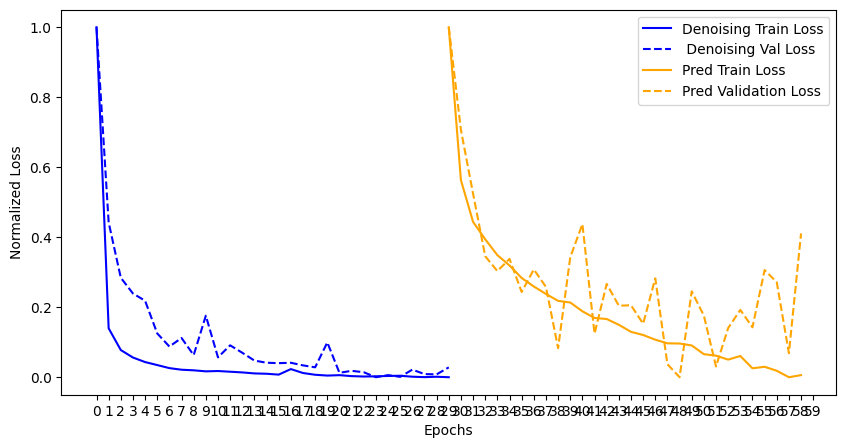

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Normalize the loss values to [0, 1] for better visualization
denoise_train_loss_list = (denoise_train_loss_list - np.min(denoise_train_loss_list)) / (np.max(denoise_train_loss_list) - np.min(denoise_train_loss_list))
denoise_val_loss_list = (denoise_val_loss_list - np.min(denoise_val_loss_list)) / (np.max(denoise_val_loss_list) - np.min(denoise_val_loss_list))
pred_train_loss_list = (pred_train_loss_list - np.min(pred_train_loss_list)) / (np.max(pred_train_loss_list) - np.min(pred_train_loss_list))
pred_val_loss_list = (pred_val_loss_list - np.min(pred_val_loss_list)) / (np.max(pred_val_loss_list) - np.min(pred_val_loss_list))

# Just plotting the losses
ax.plot(list(range(pretraining_epochs)), denoise_train_loss_list, label='Denoising Train Loss', color='blue')
ax.plot(list(range(pretraining_epochs)), denoise_val_loss_list, label=' Denoising Val Loss', color='blue', linestyle='--')
ax.plot(list(range(pretraining_epochs - 1, finetuning_epochs + pretraining_epochs - 1)), pred_train_loss_list, label='Pred Train Loss', color='orange')
ax.plot(list(range(pretraining_epochs - 1, finetuning_epochs + pretraining_epochs - 1)), pred_val_loss_list, label='Pred Validation Loss', color='orange', linestyle='--')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_xticks(list(range(0, finetuning_epochs + pretraining_epochs, 5)))
ax.set_ylabel('Normalized Loss')
plt.show()


# Prediction

In [ ]:
def pred_with_TTA(model, loader, batch_size: int=16, lr: float=0.001, stdzer:Standardizer=None):
    # Predict with test-time adaptation (TTA)
    # Since the batch size is fixed, and we only want to use a single sample for the augmentation training step,
    # we need a batch with the same sample repeated batch_size times

    # Unfreeze the encoder
    for param in model.encoder.parameters():
        param.requires_grad = True

    # Unfreeze the decoder
    for param in model.decoder.parameters():
        param.requires_grad = True

    # Freeze the prediction head
    for param in model.head.parameters():
        param.requires_grad = False

    model = deepcopy(model).to(device)
    model_before_step = deepcopy(model).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    preds = []

    for data in loader:
        
        model.set_mode('denoise')
        model.train()

        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        result = loss(out, data.x)
        result.backward()
        optimizer.step()

        model.set_mode('predict')
        model.eval()

        with torch.no_grad():
            data = data.to(device)
            out = model(data)
            pred = stdzer(out, rev=True)
            preds.extend(pred.cpu().detach().tolist())

        model = deepcopy(model_before_step)
        
    return preds[::batch_size]

In [ ]:
class RepeatedDataset(Dataset):
    def __init__(self, base_dataset, repeat: int=16):
        self.base = base_dataset
        self.repeat = repeat
        self.base_len = len(base_dataset)

    def __len__(self):
        # Each original sample is repeated `repeat` times
        return self.base_len * self.repeat

    def __getitem__(self, idx):
        sample_idx = idx // self.repeat
        return deepcopy(self.base[sample_idx])

def construct_single_sample_loader(data_df, smi_column: str, target_column: str, shuffle: bool=True, batch_size: int=16):
    # Constructs a DataLoader for a single sample repeated "batch_size" times
    # This is needed for test-time adaptation (TTA)
    # Unfortunately, therefore the actual inference time takes "batch_size" times longer

    smiles = data_df[smi_column].values
    labels = data_df[target_column].values.astype(np.float32)

    base_dataset = ChemDataset(smiles, labels, precompute=True)
    # Each sample is repeated "batch_size" times
    repeated_dataset = RepeatedDataset(base_dataset, repeat=batch_size)

    # Each batch is a single repeated sample of size "batch_size"
    loader = DataLoader(
        dataset=repeated_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True
    )
    return loader

In [24]:
# Prediction without TTA
preds = pred(best_pred_model, test_loader, mode='predict', stdzer=stdzer)  
print(f"Test RMSE: {root_mean_squared_error(preds, test_loader.dataset.labels):.3g}")
print(f"Test MAE: {mean_absolute_error(preds, test_loader.dataset.labels):.3g}")

Test RMSE: 1.4
Test MAE: 0.95


In [23]:
# Prediction with TTA
test_loader_single = construct_single_sample_loader(test_df, 'SMILES', 'LogS', shuffle=False, batch_size=batch_size)
# Depending on how large the batch size is, TTA inference will take "batch_size" times longer
preds_TTA = pred_with_TTA(best_pred_model, test_loader_single, lr=0.001, stdzer=stdzer)
print(f"Test RMSE: {root_mean_squared_error(preds_TTA, test_loader.dataset.labels):.3g}")
print(f"Test MAE: {mean_absolute_error(preds_TTA, test_loader.dataset.labels):.3g}")

Test RMSE: 1.4
Test MAE: 0.95
